# Project Milestone 2
> CS-401 - Applied Data Analysis

> *Group Padawan - Fall 2024*

>*Maxime Ducourau*, *Mehdi Zoghlami*, *Léopold Henry*, *Martin Catheland*, *Jean Perbet*

This notebook is an exploratory analysis of the [YouNiverse](https://zenodo.org/records/4650046) dataset, which contains data about **137k** english-speaking [YouTube](https://youtube.com) channels having more than **10k** subscribers, and their **73M** videos, uploaded between **2005** and **2019**. 

We chose to focus on the **gaming** category, which is one of the most popular on YouTube. We will try to adress the following **research questions**:
- What are the most popular games on YouTube ?
- Is there a link between real-world gaming events and releases, and the popularity of games on YouTube ?
- What are the most linked communities in the gaming category ?

Due to the considerable size of the dataset, we pre-filtered the original dataset to only keep the **gaming videos**, their **comments**, the **channels** that have uploaded at least one video in the gaming category and their **time-series**. We also took advantage of it to remove some useless / heavy-weight fields.

This pre-filtering is available in the notebook `prefiltering.ipynb`. Below is a summary of the datasets at our disposal, after pre-filtering.

| File | Description | Fields |
| --- | --- | -- |
| `gaming_videos.tsv` | Videos | `title`, `tags`, `upload_date`, `view_count`, `like_count`, `dislike_count`, `duration`, `channel_id`, `display_id` |
| `gaming_comments.tsv` | Comments | `author`, `video_id`|
| `gaming_channels.tsv` | Channels | `channel_id`, `channel_name`, `subscribers` |
| `gaming_timeseries.tsv` | Channels time-series | `channel_id`, `datetime`, `views`, `delta_views`, `subs`, `delta_subs`, `videos`, `delta_videos` |

We'll first examine the datasets to understand our data, its distribution and its stastistical properties, and then we'll perform some initial opersations to try to answer our previously mentioned research questions. Let's first load the libraries and create the constants we will need later.

It is important to notice that we will sometimes use the [`vaex`](https://vaex.io) library for large datasets throughout this notebook, which is a blazingly fast data frames library allowing not to load the entire dataset in memory.

In [32]:
# data frames
import pandas as pd
import vaex

# math
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import string

# progress tracking
from tqdm import tqdm
tqdm.pandas()

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# data paths
VIDEOS_PATH = "data/youniverse/filtered/yt_gaming_metadata_en.hdf5"
CHANNELS_PATH =  "data/youniverse/original/df_channels_en.tsv"
TIMESERIES_PATH = "data/youniverse/original/df_timeseries_en.tsv"
COMMENTS_PATH =  "data/youniverse/filtered/gaming_comments.tsv"

# random seed
RANDOM_STATE = 1

### Channel metadata

Let's first explore the **channels metadata**, and get some statistics.

In [3]:
channels_df = pd.read_csv(CHANNELS_PATH, sep='\t')

We quickly check the number of missing values in order to drop them if possible.

In [4]:
channels_df.isna().sum()

category_cc           128
join_date               1
channel                 0
name_cc                10
subscribers_cc          0
videos_cc               0
subscriber_rank_sb      0
weights                 0
dtype: int64

As we can see, the number of missing values is pretty negligible, so we can drop them.

In [5]:
channels_df = channels_df.dropna()

In [6]:
channels_df.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.363310e+05,136331.000000,1.363310e+05,136331.000000
mean,2.465484e+05,700.123919,3.569556e+05,7.347878
std,1.148167e+06,4527.121779,2.711055e+05,5.274846
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.889550e+04,70.000000,1.161085e+05,4.231000
50%,4.240100e+04,175.000000,3.014540e+05,6.443500
75%,1.370000e+05,443.000000,5.703800e+05,9.243000
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


Here is some important information to notice. 
- The **mean number of subscribers** is **~250k**, whereas the **standard deviation** is more than **1M** : this indicates highly varying data, with extreme outliers: this is expected looking at the **minimum** and **maximum** values, which are **10k** and **112M** respectively.
- The same applies to the **number of videos** uploaded by the channels, with a **mean** of **~700** and a **standard deviation** of **~4.5k**.

Now, let's plot the distribution of the number of subscribers per channel. 




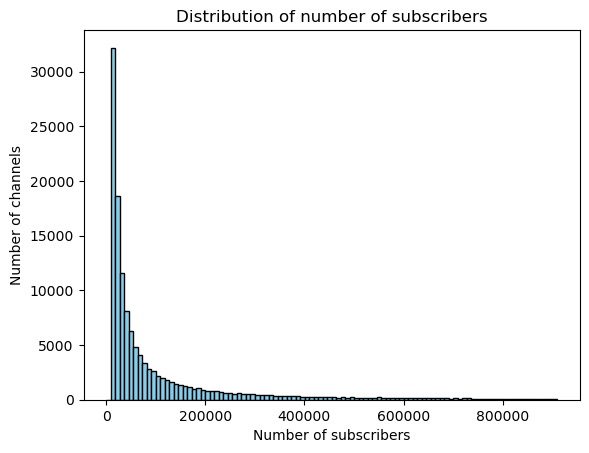

In [85]:
plt.hist(channels_df['subscribers_cc'], bins=100, range=(0, channels_df['subscribers_cc'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Number of subscribers')
plt.ylabel('Number of channels')
plt.title('Distribution of number of subscribers');

Unsurprsingly, the distribution is **right-skewed**, with a **long tail** of channels having a very high number of subscribers.

Let's bin channels depending on their popularity : different **subscriber bins** often **represent different stages** of a channel's development and **reduces variability** within each segment, which can make trends more **statistically significant** and **clearer** to interpret.

The ranges will be as follows.
- $10000$ - $100000$: **Small** channels, mostly posting videos as a hobby
- $100000$ - $1000000$: **Medium** size channels that start reaching mainstream status.
- $1000000$ or more: **Large** channels that can reach worlwide popularity, they are quite rare

In [36]:
def segment_channel(df: pd.DataFrame, lower_bound: int, upper_bound: float) -> pd.DataFrame:
    """
    Segments the channels based on the number of subscribers.
    
    Args:
        df: pd.DataFrame - the channels dataframe to segment
        lower_bound: int - the lower bound of the segment
        upper_bound: float - the upper bound of the segment
        
    Returns:
        pd.DataFrame - the segmented dataframe
    """
    return df[(df["subscribers_cc"] >= lower_bound) & (df["subscribers_cc"] < upper_bound)]

sized_channel_dfs = [
    segment_channel(channels_df, 10_000, 100_000),
    segment_channel(channels_df, 100_000, 1_000_000),
    segment_channel(channels_df, 1_000_000, float('inf'))
]

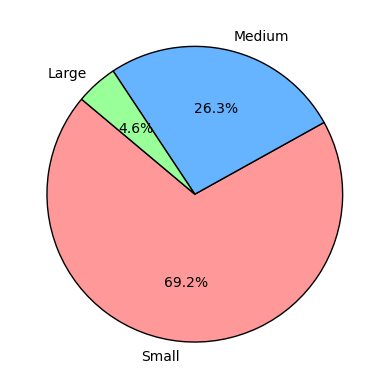

In [38]:
labels = ["Small", "Medium", "Large"]
plt.pie(
    [len(df) for df in sized_channel_dfs],
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=['#ff9999', '#66b3ff', '#99ff99'] 
);

### Time-series

Now, before going any further, let's examine the **time-series** data.

In [15]:
timeseries_df = pd.read_csv(TIMESERIES_PATH, sep='\t')

Here, a quick checks shows that there is not a single missing value.

In [16]:
timeseries_df.isna().sum()

channel             0
category        20584
datetime            0
views               0
delta_views         0
subs                0
delta_subs          0
videos              0
delta_videos        0
activity            0
dtype: int64

Again, let's just check a few statistics.

In [17]:
timeseries_df.describe()

,views,delta_views,subs,delta_subs,videos,delta_videos,activity
count,1.887250e+07,1.887250e+07,1.887250e+07,1.887250e+07,1.887250e+07,1.887250e+07,1.887250e+07
mean,4.515185e+07,3.818116e+05,1.527369e+05,1.312787e+03,4.140162e+02,2.210536e+00,4.916308e+00
std,3.633229e+08,4.062719e+06,8.073176e+05,1.864629e+04,1.439843e+03,1.469852e+01,2.998487e+01
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.330733e+06,9.197109e+03,9.033000e+03,3.375000e+01,4.100000e+01,0.000000e+00,0.000000e+00
50%,4.665598e+06,3.356228e+04,2.090667e+04,1.247250e+02,1.220000e+02,0.000000e+00,1.000000e+00
75%,1.628815e+07,1.309393e+05,7.057127e+04,5.147500e+02,3.340000e+02,2.000000e+00,4.000000e+00
max,8.411483e+10,6.659719e+09,1.125714e+08,2.061360e+07,1.418270e+05,3.158000e+04,3.159700e+04


Here, it makes no sense to study the **mean** and **standard deviation** of the **views**, **subs** and **videos** columns, as they are **cumulative** values. The meaningful insights are the following.
- The **mean weekly delta subscribers** and **views** are **~1.3k** and **~381k** respectively, with huge **standard deviations** also indicating extreme outliers.
- The **mean weekly delta videos** is **~1.5**, which seems to a reasonable value, but looking at the **maximum** tells us that one channel once posted more than **31k** videos in a week !

Now that we have a better understanding of both our channels and timeseries data, let's try to find a correlation between the **number of subscribers** and the **number of views**. We'll divide our analysis between previously determined *small*, *medium* and *large* channels.

 1. Firstly, let's merge the **number of subscribers**  with the **total number of views** for each channel, which is the last value of our timeseries for each channel.

In [24]:
views_df = timeseries_df.groupby('channel')['views'].last().reset_index()

In [42]:
sized_sub_views_dfs = [
    pd.merge(df, views_df, on='channel', how='inner')
    for df in sized_channel_dfs
]

2. Then we'll leverage the `regplot` function from `seaborn` to plot the **number of subscribers** against the **number of views** for each channel, and color the points depending on the channel's size.

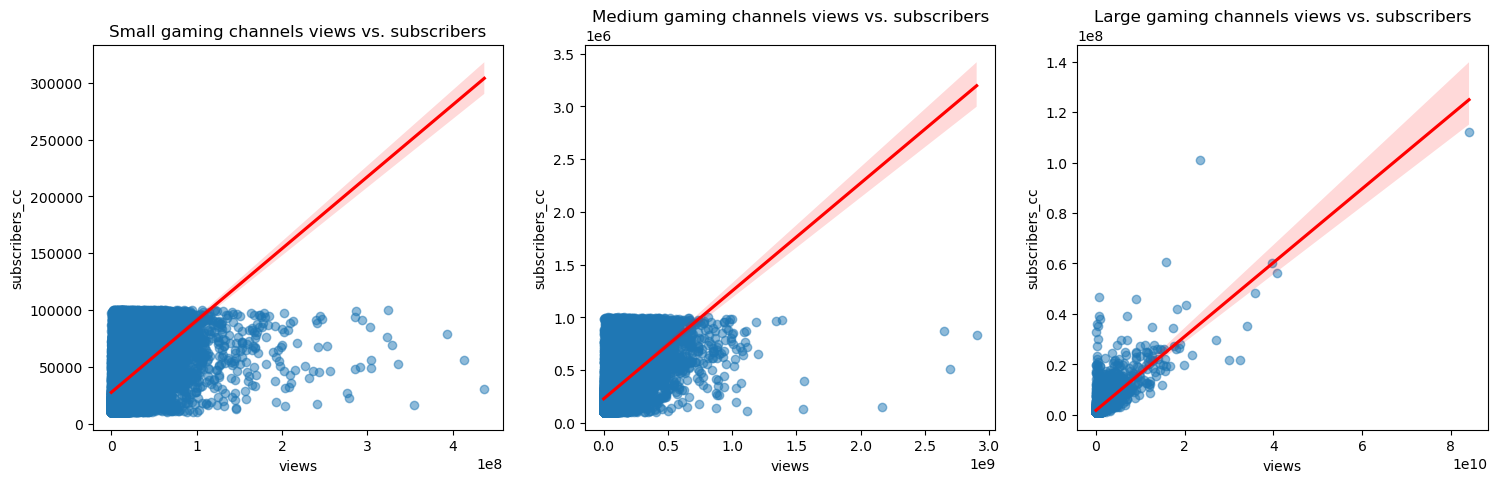

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Creates a 1x3 grid of plots
for i, (df, name) in enumerate(zip(sized_sub_views_dfs, ["Small", "Medium", "Large"])):
    sns.regplot(
        data=df,
        x="views",
        y="subscribers_cc",
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "red"},
        ax=axes[i]
    )
    axes[i].set_title(f"{name} gaming channels views vs. subscribers")

In [ ]:
print("Correlation coefficient between views and subscribers for gaming channels:")
for df, name in zip(sized_sub_views_dfs, ["Small", "Medium", "Large"]):
    corr = df["views"].corr(df["subscribers_cc"])
    print(f"{name} channels: {corr:.2f}")

Correlation coefficient between views and subscribers:
Small channels: 0.39
Medium channels: 0.49
Large channels: 0.77


We have evidence that the number of views is positively correlated to the number of subscribers. This correlation is weak for small channels, moderate for medium channels and strong for large channels. 

We interpret this as follows. Small channels tend to produce content that people will watch **regardless of their subscriber count**, only because they are interested, whereas medium and large channels tend to have a more loyal audience that will watch **most of their content** due to their **popularity**.

### Video metadata

Let's dive into the **videos metadata**.

In [60]:
videos_df = vaex.open(VIDEOS_PATH).dropna()

First, let's get some insights about our data, starting with the number of gaming videos we have at our disposal.

In [61]:
len(videos_df)

13720302

We have more than **13.5 million** videos, that's quite a good knowledge base ! Let's get some statistics.

In [62]:
videos_df.describe()

,channel_id,duration,tags,title,upload_date,view_count
data_type,string,int64,large_string,string,string,float64
count,13720302,13720302,13720302,13720302,13720302,13720302
NA,0,0,0,0,0,0
mean,--,1432.52809012513,--,--,--,75982.51334001249
std,--,2791.670343,--,--,--,715529.588594
min,--,1,--,--,--,0.0
max,--,153430,--,--,--,1142517641.0


It's interesting to see that, **on average**, between may 2005 and october 2019, the **~137k** studied english channels have **~76k views** per video, and their videos last **~24 minutes**. The same pattern applies for the **views** as for the channels **subscribers**, which makes sense: there are extreme outliers which add a lot of vairance to the metrics.

Let's try to visualize the distribution of the number of views and the duration of the videos. We'll create a sample of $5\%$ of the data to avoid runtime issues, while still being representative of the whole dataset.

In [24]:
videos_sample_df = videos_df.sample(frac=0.05, random_state=RANDOM_STATE)
print(f'There are {len(videos_sample_df)} videos in the sample dataset.')

There are 686015 videos in the sample dataset.


We convert back our `vaex` DataFrame to a `pandas.DataFrame` to have more control over visualization.

In [25]:
videos_sample_df = videos_sample_df.to_pandas_df()

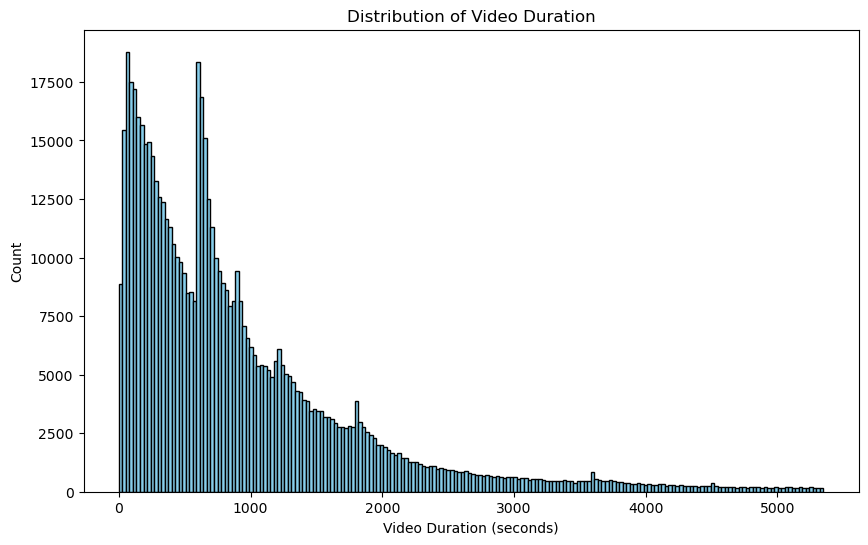

In [ ]:
plt.hist(videos_sample_df['duration'], bins=200, range=(0, videos_sample_df['duration'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Video duration (seconds)')
plt.ylabel('Number of videos')
plt.title('Distribution of Video Duration');

It's very interesting here to notice the peak at **10min**, which corresponds to the minimum duration of a video to be **monetized** on YouTube.

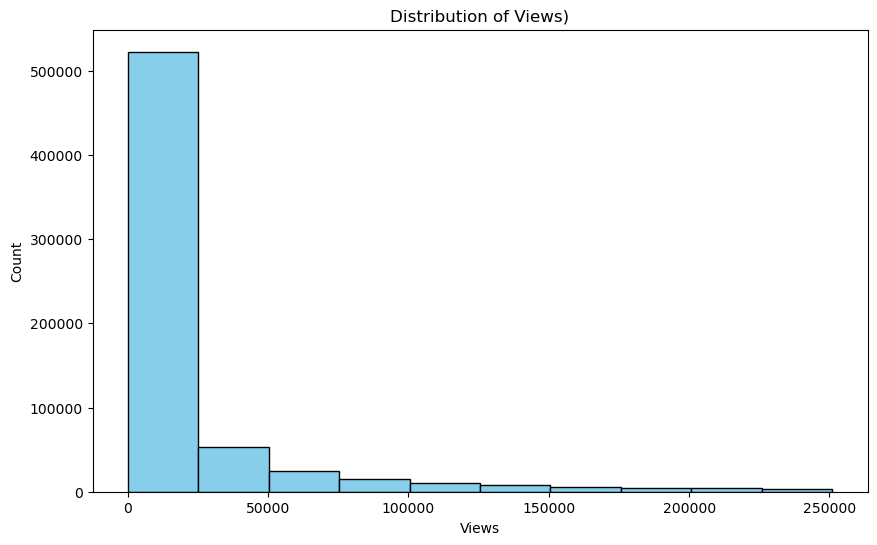

In [ ]:
plt.hist(videos_sample_df['view_count'], bins=10, range=(0, videos_sample_df['view_count'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Views')
plt.ylabel('Number of videos')
plt.title('Distribution of Views');

Now, let's visualize the distribution accross time of the **upload date** of our gaming videos.

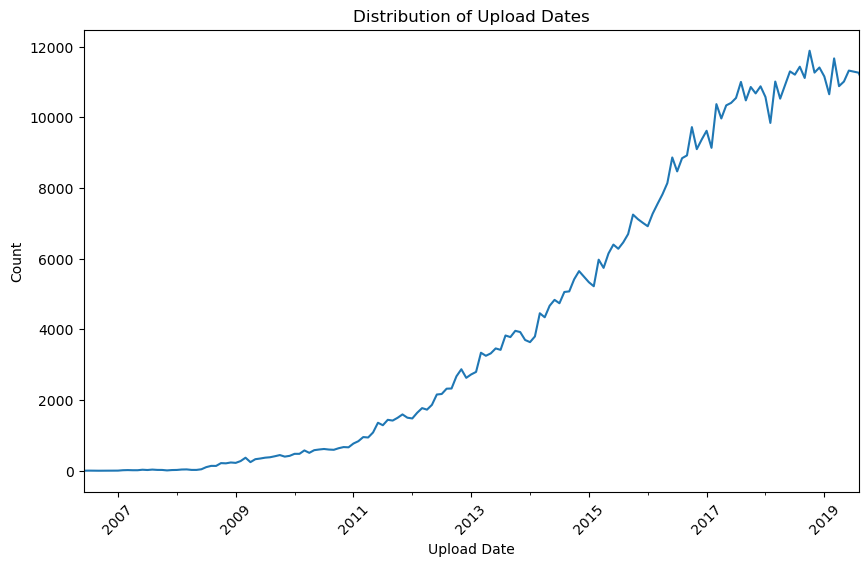

In [ ]:
videos_sample_df["upload_date"] = pd.to_datetime(videos_sample_df["upload_date"])
videos_sample_df['year_month'] = videos_sample_df['upload_date'].dt.to_period('M')
monthly_counts = videos_sample_df['year_month'].value_counts().sort_index()

monthly_counts.plot(kind='line')
plt.xlim(right=pd.Timestamp('2019-08-31'))
plt.xlabel('Upload Date')
plt.ylabel('Count')
plt.title('Distribution of Upload Dates')
plt.xticks(rotation=45);


It follows the general trend of YouTube, with **increasing uploads** over time.

#### Most common tags & titles

Now, let's dive deeper into our `title` and `tags` field. We noticed that the `tags` field is a list of tags, where they're separated by a comma. What would be super interesting to do is extracting all different tags and see which ones are the most common. Since we start working with the whole dataset again, we take our `vaex` DataFrame.

In [63]:
tag_counts = videos_df['tags'].str.lower().str.split(',').value_counts()
tag_counts.head(15)

gameplay       2799110
game           1491604
walkthrough    1440884
gaming         1347656
games          1226016
playthrough    1212959
let's play      914140
                897772
pc              852774
funny           809834
play            785450
commentary      771141
minecraft       694047
ps4             665640
guide           658469
dtype: int64

Very interesting ! We can already see that `minecraft` is tagged on a huge number of videos.

Let's apply the same methodology to `title` filed, but his time splitting the words by space.

In [ ]:
title_counts = videos_df['title'].str.lower().str.split().value_counts()
title_counts[".head(15)"]

-           8079694
|           2963953
the         2737471
of          1665070
part        1473303
2           1309097
gameplay    1284736
vs          1033134
to           909196
&            869081
in           837095
and          778998
play         756225
3            721272
let's        679141
dtype: int64

As we can see, this is less representative. We can try to check some famous games in the `tag_counts` to evaluate their interest.

In [73]:
print(f'Number of tags containing "fifa": {tag_counts["fifa"]}')
print(f'Number of tags containing "minecraft": {tag_counts["minecraft"]}')
print(f'Number of tags containing "league of legends": {tag_counts["league of legends"]}')

Number of tags containing "fifa": 99630
Number of tags containing "minecraft": 694047
Number of tags containing "league of legends": 207845


## Video games dataset

 Now, we will cross our dataset with another one, containing an almost-comprehensive list of more than **41k** unique commercial video games. It is available [here](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games). So as to keep this study manageable, we will only focus on the first **~1k** most popular games, since we assume they represent the vast majority of YouTube gaming videos.
 
Let's load and filter out the dataset.

In [74]:
games_df = pd.read_csv('data/games.csv', index_col=0).drop_duplicates("Title").reset_index(drop=True)
games_df.head(3)

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5,21K,4.1K,5.6K,5.5K,4.6K,3K
1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
2,Hades,"Dec 07, 2018",['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3,25K,3.5K,7.3K,4K,3.2K,2.1K


We'll use the `Plays` feature to estimate the popularity of the games, and we'll use a cutoff of **2k** games to keep.

In [75]:
cutoff = 2000

games_df["Plays_Numeric"] = games_df["Plays"].apply(lambda x: float(x.replace('k', '').replace('K', '')) * 1000 if "k" in x or "K" in x else float(x))
games_df = games_df.sort_values(by="Plays_Numeric", ascending=False).drop(columns=["Plays_Numeric"])
games_df = games_df.iloc[:cutoff]

Then, we'll remove game names that are too short and those that are common english names, as they are likely to be noise. We pick the list of common english names [here](https://github.com/dwyl/english-words).

In [77]:
with open("data/words_alpha.txt", "r") as f:
    words = {line.strip() for line in f}

games_df = games_df[(games_df["Title"].str.len() > 4) & ~(games_df["Title"].str.lower().isin(words))].reset_index(drop=True)

Some video games are just specific versions of other games, see for instance the *Tetris* example.

In [80]:
games_df[games_df["Title"].str.contains("Tetris")]

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
87,Tetris,"Nov 01, 1989",['Nintendo'],Tetris is a tile-matching puzzle video game. T...,['NES'],"['Arcade', 'Puzzle']",4.1,11K,60,211,86,797,410


Since we're not interested in specific versions but rather in the game itself, we will remove all games that are a superstring of another game.

In [79]:
games_df = games_df[games_df['Title'].apply(lambda x: not any(other in x for other in games_df['Title'] if x != other))].reset_index(drop=True)

Since the titles and tags are quite noisy and may contain a lot of irrelevant information as well as different names for a given video game (e.g. *LoL* for *League of Legends*, *gta* for *Grand Theft Auto V*, etc.), we searched for a good and effective way to extract the game names from the `title` and `tags` field. 

- We first tried to use **TF-IDF** embeddings, but it did not yield satisfactory results are rare words were given too much importance : a title containing the words *mafia* and *minecraft* would be assigned to the game *mafia ii*, even though it is more likely to be about *minecraft*. 
- We then tried to use **Sentence Transformers** to embed the game names and the titles/tags, and then compute the cosine similarity between them. It did not yield satisfactory results either. 

- What works the best is in fact quite simple. We lowercase and remove punctuation from all video games names, titles and tags, and then we start by looking if a game name is entirely contained in the video title. If it is, we assign the video to this game. If it is not, we look if a game name is entirely contained in one of the tags. If there is only one game name, we assign the video to this game. Otherwise, if there is no game or several games in the tags, we do not assign the video. This way, we can assign a game to **~50%** of the videos.

During **PM3**, we could go further in our analysis by leveraging **LLMs** to acomplish this task for more videos, but this would require a lot of computational power and time. We could also investigate the use of game initials, since it is a commonly used pattern in video tags (e.g. *gta v* for *Grand Theft Auto V*, *lol* for *League of Legends*, *r6* for *Tom Clancy's Rainbow Six Siege*, *cod* for *Call of Duty*, etc.)

 We'll only provide a **Proof-of-Concept** here, as it is quite slow (~1h) to process the whole dataset. We'll only process the previously devised sample (`pandas_sample_df`) of $5\%$ of the data.

In [81]:
def preprocess_name(name: str) -> str:
    """
    Convert to lowercase and remove punctuation from the name.
    
    Args:
        name: str - Name of the game
    
    Returns:
        str - Processed name
    """
    return name.lower().replace(",", " ").translate(str.maketrans('', '', string.punctuation))


videos_sample_df["title"] = videos_sample_df["title"].apply(preprocess_name)
videos_sample_df["tags"] = videos_sample_df["tags"].apply(preprocess_name)
game_titles = games_df["Title"].apply(preprocess_name).tolist()

NameError: name 'videos_sample_df' is not defined

In [20]:
def map_to_game(title: str, tags: str) -> str:
    """
    Map the video to a game based on the title and tags.
    
    Args:
        title: str - The title of the video.
        tags: str - List of tags of the video.
        
    Returns:
        str - The name of the game if the video is related to a game, else None.
    """
    for game in game_titles:
        if game in title:
            return game
     
    matched_games = []
    for game in game_titles:
        if game in tags:
            matched_games.append(game)
    if len(matched_games) == 1:
        return matched_games[0]
    else:
        return None

In [ ]:
videos_sample_df["video_game"] = videos_sample_df.progress_apply(lambda row: map_to_game(row["title"], row["tags"]), axis=1)

100%|██████████| 686015/686015 [01:37<00:00, 7016.04it/s]


In [ ]:
print(f'Percentage of classified games over the sample : {100 - (videos_sample_df["video_game"].isna().sum() / len(videos_sample_df) * 100):.2f}%')

Percentage of classified games over the sample : 49.68%


Almost half of our sample was assigned a game ! We can now explore what are the top-15 most popular games in our dataset !

In [ ]:
videos_sample_df[videos_sample_df["video_game"].notna()].value_counts("video_game")[:15]

video_game
minecraft            38384
fortnite             18745
call of duty         18380
league of legends    11799
roblox               10456
grand theft auto     10201
dota 2                7422
super smash bros      4632
final fantasy         4066
world of warcraft     3875
the sims              3783
assassins creed       3694
resident evil         3266
mortal kombat         3195
clash of clans        3120
Name: count, dtype: int64

Unsurprisingly, YouTube is dominated by *minecraft*, *fortnite*, *call of duty*, *league of legends*, ... This concludes our analysis on the gaming videos metadata.